# Exercise 01: Multi-armed bandits

In this exercise, we will look at multi-armed bandits as an introduction to solving a RL program. Compared to other tasks that we will look at later, multi armed bandits are simpler: there is only a single state. 

Please read _Chapter 2: Multi-armed Bandits_, section 2.1 to 2.4 in preparation for this exercise. 

Note, if you do not want to use the gpuhub, then you can download the files, solve them on your computer and then upload them again, but it is recommended to use the provided infrastructure.

You generally have 2 weeks to submit the exercises.

In [51]:
import numpy as np
import math
import matplotlib.pyplot as plt

# progress bar, see https://github.com/tqdm/tqdm
import tqdm
import time

# OpenAI/Farama gym
# https://github.com/Farama-Foundation/Gymnasium
import gymnasium as gym


### Multi-armed bandit

First we want to program a simulation of the multi armed bandit. We do that in a separate class.

In [52]:

class MultiArmedBandit:
    """
    Class for multi-armed bandits as described in the RL Book.
    """
    def __init__(self, nr_arms: int):
        """
        Initialize the bandit with the number of arms.
        """
        # The true value of each arm is drawn from a Normal distribution with 0 mean and unit variance
        self._values = np.random.standard_normal(nr_arms)

    def sample(self, nr_arm: int) -> float:
        """
        Sample one of the arms and return the value
        """
        return np.random.normal(loc=self._values[nr_arm], scale=1.0)

In [53]:
# lets test the class
nr_arms = 10
np.random.seed(0)
bandit = MultiArmedBandit(nr_arms)
reward = bandit.sample(2)
# check that seed works
assert math.isclose(reward, 1.1227815552666), 'check usage of random number generator'

### Environment for RL

There are many frameworks for reinforcement learning. One popular interface for the environment part was OpenAI's gym: https://github.com/openai/gym. This has now been taken over by the Farama Foundation to maintain and been renames gymnasium: https://github.com/Farama-Foundation/Gymnasium

IT is a simple interface that captures the interaction of an agent or trainer with the environment by defining a base class and action and observation spaces. It is used as a base in many other frameworks and we will continue to use it in this course.

We will now wrap the multi-armed bandit class above in this environment.

Whenever an action is done on the environment, the `step` function will be called. The step function should return the observation, the reward, done (a flag that signifies that the episode is done), truncation (a flag that signifies that the episode is not done but truncated) and an info object. In this example, we will not need the observation, as there are no states. However, we must return the reward.

The `reset` function resets the environment. Here we change the values of the arms. It also returns an observation and the info object (both are not needed here).


In [54]:
class MultiArmedBanditEnv(gym.Env):
    
    # we fix the number of arms
    nr_arms = 10
    
    # steps for one episode
    max_steps = 1000
    
    # action space consists of the sampling each of the arms
    action_space = gym.spaces.Discrete(nr_arms)
    
    # no observations for this environment
    observation_space = None
    
    def __init__(self):
        self._seed = None
    
    def step(self, action):
        reward = self._bandit.sample(action)
        self._steps += 1
        
        # return a tuple of observation, reward, done, info
        return None, reward, self._steps == self.max_steps, None, None
        
    def reset(self):
        if self._seed is not None:
            self._seed += 1
        #
        np.random.seed(self._seed)
        self._bandit = MultiArmedBandit(10)
        self._steps = 0
        return None, None
        
    def seed(self, seed=None):
        self._seed = seed
        return seed

In [55]:
# test the class
env = MultiArmedBanditEnv()
env.seed(1)
env.reset()
done = False
obs, reward, done, trunc, info = env.step(0)
assert math.isclose(reward, 0.1346961971409537), 'Check random number generator'
assert done == False
while not done:
    obs, reward, done, trunc, info = env.step(0)


### Agent implementation

The gym environment does not include an agent definition. So we use our own class here. We define a base class for the interface. We add the env in the constructor, so that the agent can read the action and (later) observation spaces. We already use the correct signature for a more complicated environment with observations, even as our environment currently returns `None` as the observation.

The `step_first` function will be called for the first action, for all the following steps the `step` function is called, that includes arguments for the reward from the previous step and done, indicating that the episode has ended and the environment should be reset.

(The `train` function will be used later to train our agent)


In [56]:
class Agent:
    """
    Class for an agent in our env.
    """
    def __init__(self, action_space):
        self._action_space = action_space

    def reset(self):
        """
        Reset the learning of the agent to an initial condition, so it can be used again, for example to
        compare different runs.
        """
        pass

    def step_first(self, observation) -> float:
        """
        First step after reset or initialization with the first observation from the environment.
        """
        raise NotImplementedError

    def step(self, observation, reward, done) -> float:
        """
        Step in the environment. The reward given is the returned reward from the last action.
        """
        raise NotImplementedError

    def train(self, nr_episodes):
        """
        Train the agent in the given environment
        """
        raise NotImplementedError

### Random Agent

We first want to implement a random agent that we can use for evaluation and comparison.

Complete the code below to take a random action in both the `step_first` and the `step` method. Use `np.random.randint` for this. (Hints will often be included in the exercises, but please check the manual for the exact functions. Help for numpy should be available under the menu entry <i>Help<i>

In [57]:
class RandomAgent(Agent):
        
    def reset(self):
        pass
    
    def step_first(self, observation)->float:
        # YOUR CODE HERE
        return np.random.randint(self._action_space.n)
        
    def step(self, observation, reward, done):
        # YOUR CODE HERE
        return np.random.randint(self._action_space.n)
    
    def train(self, nr_episodes):
        pass
    

In [58]:
# Test the implementation
env = MultiArmedBanditEnv()
agent = RandomAgent(env.action_space)
np.random.seed(0)
action = agent.step_first(None)
assert action == 5
action = agent.step(None, 1, False)
assert action == 0

### Running an experiment

In order to run an experiment we have to link the agent and the environment. To get more accurate estimations, we perform the experiment multiple times and look at the average return at a specific time step across those experiment.


In [59]:
def run_experiment(agent, env, num_repetitions: int = 400, display_progress=True):
    # we repeat an experiment a number of times and look at the mean values of the reward obtained in that
    # time step
    all_rewards = []
    

    pbar = tqdm.tqdm(total=num_repetitions, disable=not display_progress)
        
    for _ in range(num_repetitions):
        # reset both the environment and the learned agent
        obs = env.reset()
        agent.reset()
        
        # do the first time step
        step = 0
        action = agent.step_first(obs)
        rewards_per_step = []
        done = False
        
        # repeat until episode ends
        while not done:
            obs, reward, done, _ , _ = env.step(action)
            rewards_per_step.append(reward)
            action = agent.step(obs, reward, done)
            step += 1
            
        all_rewards.append(rewards_per_step)
        pbar.update(1)
    
    return np.mean(all_rewards, axis=0)
            

Let us run the experiment and look at the average reward. As it is all random, it does not improve over time...

100%|██████████| 400/400 [00:01<00:00, 235.92it/s]


Text(0.5, 1.0, 'Random Agent')

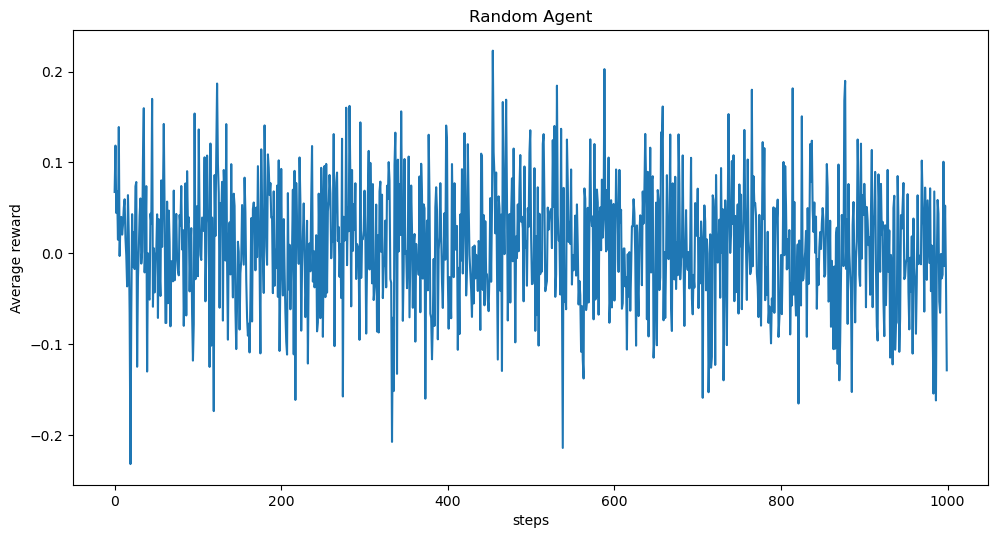

In [60]:
env = MultiArmedBanditEnv()
agent = RandomAgent(env.action_space)
mean_reward_random = run_experiment(agent, env, 400)

plt.figure()
plt.plot(mean_reward_random)
plt.xlabel('steps')
plt.ylabel('Average reward')
plt.title('Random Agent')

### Agent implementation for greedy and epsilon greedy policy

Next we want to implement a greedy and a epsilon greedy policy. These policies are with respect to a value function, which captures our current estimated reward and is learned while interacting with the environment.

Both policies need to select a random action in case the current value is tied. The standard implementation of arg_max will always return the first value, so we need to reprogram that first. Complete the definition of the function below to return either the index of the maximal value or a random index in case of ties.

Use `np.random.choice` to select the index.


In [61]:
def max_arg_with_ties(q):
    max_value = -math.inf
    tied_index = []
    
    for i in range(len(q)):
        if q[i] > max_value:
            max_value = q[i]
            tied_index = [i]
        elif q[i] == max_value:
            tied_index.append(i)
    if len(tied_index) > 1:
        return np.random.choice(tied_index)
    return tied_index[0]

In [62]:
m = max_arg_with_ties([0, 0, 1, 0.5])
assert m == 2

np.random.seed(0)
m1 = max_arg_with_ties([0, 1, 1, 0.5])
m2 = max_arg_with_ties([0, 1, 1, 0.5])
# with that seed, the result should be different
assert m1 != m2

### Greedy Agent

Now we can implement a greedy agent that will always select the action with the highest expected return. Look at section 2.4 in the book how to update the expected return, or the slides from the lecture.

The agent should also track the number of times that a specific action has been taken, so that we can visualise its actions. 

Complete the implementation below.

In [63]:
class GreedyAgent(Agent):
    def __init__(self, action_space: gym.spaces.Discrete):
        super().__init__(action_space)
        self._q_values = np.zeros(self._action_space.n)
        self._action_count = np.zeros(self._action_space.n)
        self._last_action = None
        
    # we add some methods to return the q value and the action count
    def get_q_values(self):
        return self._q_values
    
    def get_action_count(self):
        return self._action_count
        
    def reset(self):
        # in the reset, you must clear all the learned value for a new environment
        # YOUR CODE HERE
        self._q_values = np.zeros(self._action_space.n)
        self._action_count = np.zeros(self._action_space.n)
        self._last_action = None
        
    def step_first(self, observation)-> float:
        # in the first step you will just have to return the action, 
        # however as the reward for the action is only known later, you must remember the action
        # YOUR CODE HERE
        choosen_action = max_arg_with_ties(self._q_values)
        self._last_action = choosen_action
        self._action_count[self._last_action] += 1
        return choosen_action
        
        
    def step(self, observation, reward, done) -> float:
        # you should update the q values with the new observation here
        # and also return an action

        # update q_values
        #self._q_values[self._last_action] = (self._action_count[self._last_action] * self._q_values[self._last_action] + reward) / (self._action_count[self._last_action] + 1)

        # Update the Q-Value
        q_value = self._q_values[self._last_action]
        # General update formula
        self._q_values[self._last_action] = q_value + 1/ self._action_count[self._last_action] * (reward - q_value)
        
        # return an action
        choosen_action = max_arg_with_ties(self._q_values)
        self._last_action = choosen_action
        self._action_count[self._last_action] += 1
        return choosen_action
        

In [64]:
# check the agent
env = MultiArmedBanditEnv()
env.seed(1)
agent = GreedyAgent(env.action_space)
obs = env.reset()
action = agent.step_first(obs)

# should return 4 with this initialization of the seed
assert action == 4
count = agent.get_action_count()
assert count[action] == 1
action2 = agent.step(None, reward=1.0, done=False)

# as it is greedy the same action must be returned
assert action2 == action
q = agent.get_q_values()
assert q[action] == 1.0

action3 = agent.step(None, reward=2.0, done=False)
q = agent.get_q_values()
assert q[action] == 1.5
count = agent.get_action_count()
assert count[action] == 3

Let us run an experiment to see how the greedy agent performs.


100%|██████████| 400/400 [00:02<00:00, 194.77it/s]


Text(0.5, 1.0, 'Greedy Agent')

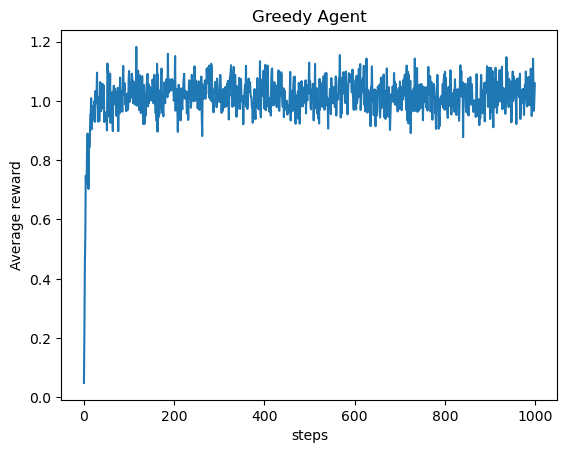

In [19]:
env = MultiArmedBanditEnv()
env.seed(1)
agent = GreedyAgent(env.action_space)

mean_reward_greedy = run_experiment(agent, env)

plt.figure()
plt.plot(mean_reward_greedy)
plt.xlabel('steps')
plt.ylabel('Average reward')
plt.title('Greedy Agent')


100%|██████████| 1/1 [00:00<00:00, 184.60it/s]


Text(0.5, 1.0, 'Greedy Agent')

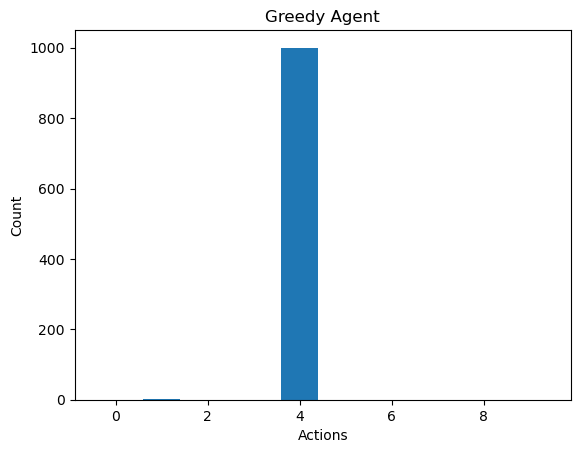

In [20]:
env = MultiArmedBanditEnv()
env.seed(9)
agent = GreedyAgent(env.action_space)

mean_reward_greedy = run_experiment(agent, env, num_repetitions=1)
plt.figure()
plt.bar(range(10), agent.get_action_count())
plt.xlabel('Actions')
plt.ylabel('Count')
plt.title('Greedy Agent')

Text(0.5, 1.0, 'Greedy Agent')

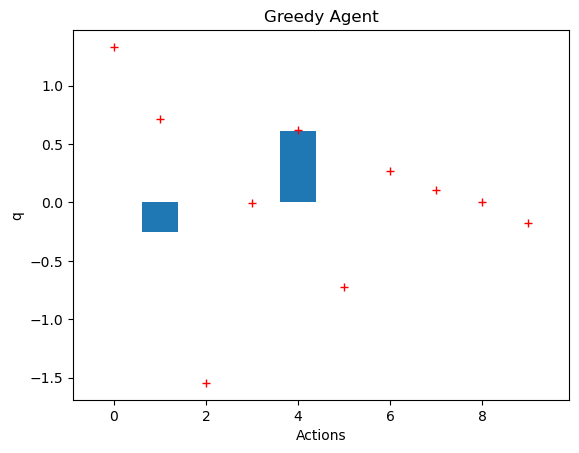

In [21]:
# lets plot the action values too, as well as the real values
plt.figure()
plt.bar(range(10), agent.get_q_values())
plt.plot(range(10), env._bandit._values, 'r+')
plt.xlabel('Actions')
plt.ylabel('q')
plt.title('Greedy Agent')

As we can see the chosen action was in that case not the best one. The estimation (blue) of the value of the most frequently taken action (4) is very good, as this action has been taken a lot of time. But only one other action(1) was tried.

### Epsilon Greedy Agent

We now want to add more exploration and implement an Epsilon Greedy agent.

The starting q values are all 0 in this implementation, however there are cases where we might want to initialise the values differently. So even in the `step_first` you should take the epsilon-greedy action and not a random action. (Otherwise, you will not get the same results, as a different number of random numbers have been calculated)

In [22]:
class EpsilonGreedyAgent(Agent):
    def __init__(self, action_space, epsilon: float):
        super().__init__(action_space)
        self._epsilon = epsilon
        self._q_values = np.zeros(self._action_space.n)
        self._action_count = np.zeros(self._action_space.n)
        self._last_action = None
        
    def get_q_values(self):
        return self._q_values
    
    def get_action_count(self):
        return self._action_count
    
    def reset(self):
        self._q_values = np.zeros(self._action_space.n)
        self._action_count = np.zeros(self._action_space.n)
        self._last_action = None
        
    def step_first(self, observation) -> float:
        if np.random.rand() < self._epsilon:
            np.random.choice(self._action_space.n) #exploration
        greedy_action = max_arg_with_ties(self._q_values)
        self._last_action = greedy_action

        self._action_count[self._last_action] += 1
        return self._last_action
        
    def step(self, observation, reward, done):

         # Update the Q-Value
        q_value = self._q_values[self._last_action]
        # General update formula
        self._q_values[self._last_action] = q_value + 1/ self._action_count[self._last_action] * (reward - q_value)
        
        if np.random.rand() < self._epsilon:
            self._last_action = np.random.choice(self._action_space.n) #exploration
        else: 
            greedy_action = max_arg_with_ties(self._q_values)
            self._last_action = greedy_action

        self._action_count[self._last_action] += 1
        return self._last_action
        

        

In [23]:
# check the agent
env = MultiArmedBanditEnv()
env.seed(1)
agent = EpsilonGreedyAgent(env.action_space, 0.1)
obs = env.reset()
action = agent.step_first(obs)

# should return 5 with this initialization of the seed
assert action == 5
count = agent.get_action_count()
assert count[action] == 1
action2 = agent.step(None, reward=1.0, done=False)

assert action2 == action
q = agent.get_q_values()
assert q[action] == 1.0

action3 = agent.step(None, reward=2.0, done=False)
q = agent.get_q_values()
assert q[action] == 1.5
count = agent.get_action_count()
assert count[action] == 3

Let as see how the new agent performs.

100%|██████████| 400/400 [00:02<00:00, 153.93it/s]


Text(0.5, 1.0, 'Epsilon Greedy Agent')

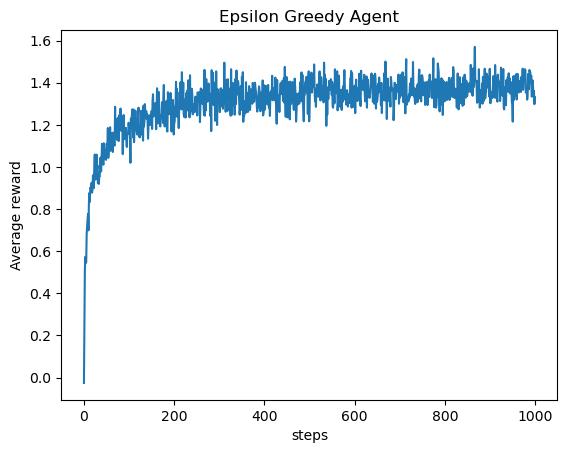

In [24]:
env = MultiArmedBanditEnv()
env.seed(1)
agent = EpsilonGreedyAgent(env.action_space, 0.1)

mean_reward_greedy = run_experiment(agent, env)

plt.figure()
plt.plot(mean_reward_greedy)
plt.xlabel('steps')
plt.ylabel('Average reward')
plt.title('Epsilon Greedy Agent')

100%|██████████| 1/1 [00:00<00:00, 148.81it/s]


Text(0.5, 1.0, 'Epsilon Greedy Agent')

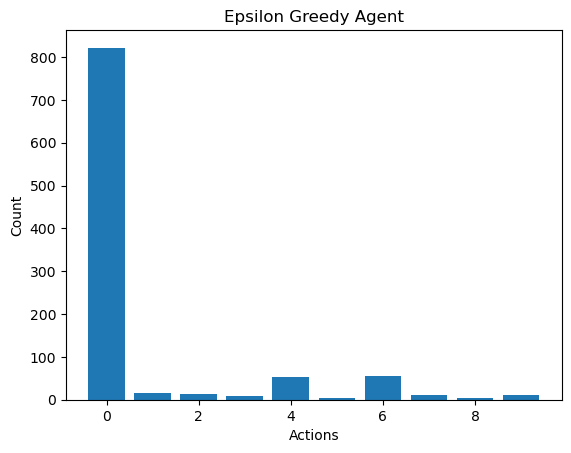

In [25]:
env = MultiArmedBanditEnv()
env.seed(9)
agent = EpsilonGreedyAgent(env.action_space, 0.1)

mean_reward_greedy = run_experiment(agent, env, num_repetitions=1)
plt.figure()
plt.bar(range(10), agent.get_action_count())
plt.xlabel('Actions')
plt.ylabel('Count')
plt.title('Epsilon Greedy Agent')

Text(0.5, 1.0, 'Epsilon Greedy Agent')

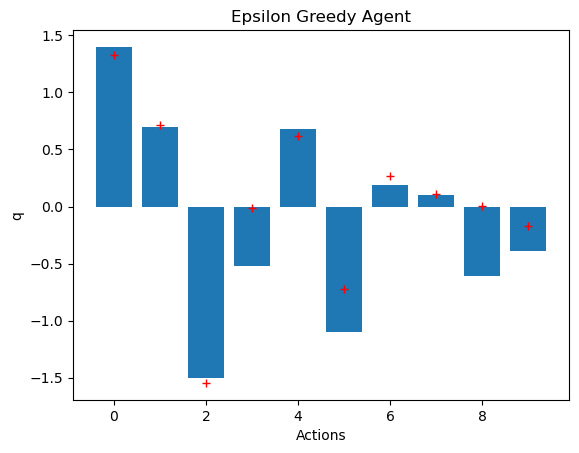

In [26]:
plt.figure()
plt.bar(range(10), agent.get_q_values())
plt.plot(range(10), env._bandit._values, 'r+')
plt.xlabel('Actions')
plt.ylabel('q')
plt.title('Epsilon Greedy Agent')

As we can see, the epsilon greedy policy does a much better job to estimate the action values of all the different actions. 

Next we want to look at different epsilon values and see how their performance compares.

100%|██████████| 400/400 [00:02<00:00, 177.27it/s]


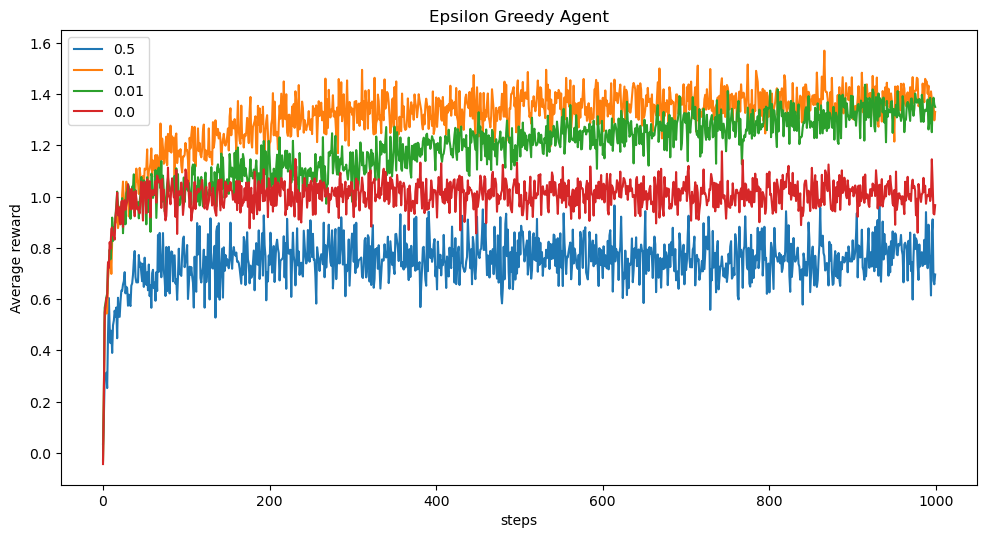

In [27]:
# we now want to try different epsilon values
results = {}
for epsilon in [0.5, 0.1, 0.01, 0.0]:
    env = MultiArmedBanditEnv()
    env.seed(1)
    agent = EpsilonGreedyAgent(env.action_space, epsilon)
    rewards = run_experiment(agent, env, num_repetitions=400)
    results[epsilon] = rewards
    
# plot the results
plt.rcParams['figure.figsize'] = [30/2.54, 15/2.54]
plt.figure()
for k in results.keys():
    plt.plot(results[k], label=k)
plt.xlabel('steps')
plt.ylabel('Average reward')
plt.legend()
plt.title('Epsilon Greedy Agent')

plt.show()

### UCB agent

As the last agent, we want to implement the ucb agent using the formula from the slides to determine the action taken.

In [47]:
class UCBAgent(Agent):
    def __init__(self, action_space, coefficient: float):
        super().__init__(action_space)
        self._coefficient = coefficient
        self._q_values = np.zeros(self._action_space.n)
        # we initialize the counts to 1, to avoid dividing by 0
        self._action_count = np.ones(self._action_space.n)
        self._last_action = None
        self._steps = 0
    
    def reset(self):
        self._q_values = np.zeros(self._action_space.n)
        self._action_count = np.ones(self._action_space.n)
        self._last_action = None
        self._steps = 0
        
    def step_first(self, observation) -> float:
        upper_confidence_bounds = []
        log_term = math.log2(self._steps) if self._steps > 1 else 1
        for i in range(0, self._action_space.n):
            upper_confidence_bounds.append(self._q_values[i] + self._coefficient*math.sqrt(log_term / self._action_count[i]))
            
        self._steps += 1
        self._last_action = max_arg_with_ties(upper_confidence_bounds)  
        self._action_count[self._last_action] += 1
        return self._last_action   
        
    def step(self, observation, reward, done):
        # Update the Q-Value only if the action count is nonzero
        q_value = self._q_values[self._last_action]
        self._q_values[self._last_action] = q_value + 1/ self._action_count[self._last_action] * (reward - q_value)

        self.step_first(None)
        return self._last_action
        

Text(0.5, 1.0, 'UCB Agent')

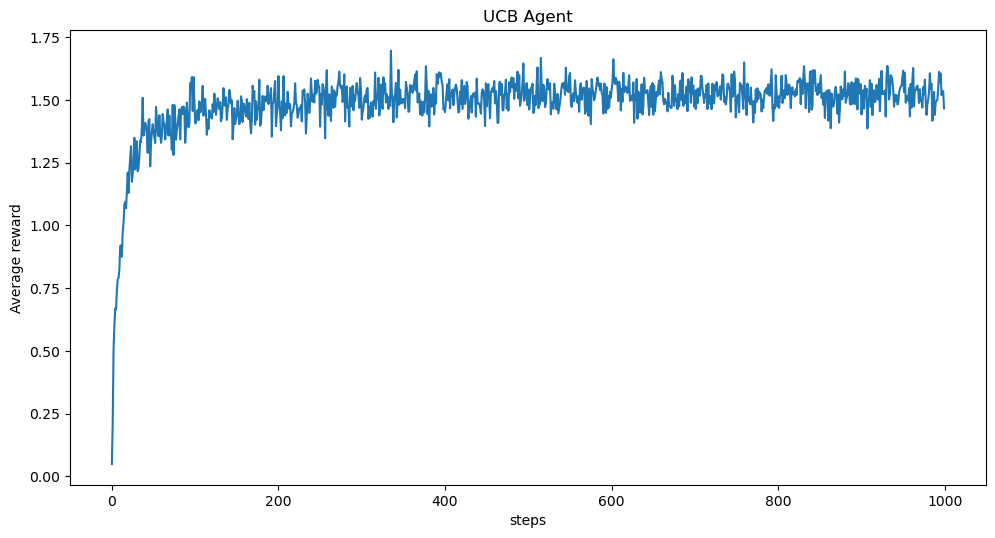

In [48]:

env = MultiArmedBanditEnv()
env.seed(1)
agent = UCBAgent(env.action_space, 0.7)
rewards = run_experiment(agent, env, num_repetitions=400, display_progress=False)

plt.figure()
plt.plot(rewards)
plt.xlabel('steps')
plt.ylabel('Average reward')
plt.title('UCB Agent')


Lets compare the epsilon greedy and the UCB approaches.

100%|██████████| 400/400 [00:02<00:00, 134.54it/s]


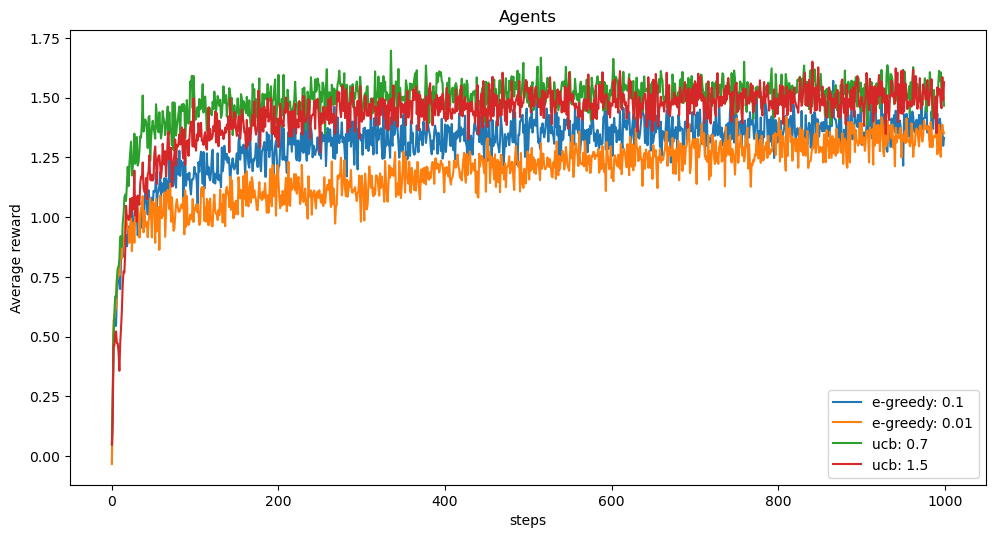

In [49]:
results_greedy = {}
for epsilon in [0.1, 0.01]:
    env = MultiArmedBanditEnv()
    env.seed(1)
    agent = EpsilonGreedyAgent(env.action_space, epsilon)
    rewards = run_experiment(agent, env, num_repetitions=400)
    results_greedy[epsilon] = rewards
    
results_ucb = {}
for coefficient in [0.7, 1.5]:
    env = MultiArmedBanditEnv()
    env.seed(1)
    agent = UCBAgent(env.action_space, coefficient)
    rewards = run_experiment(agent, env, num_repetitions=400)
    results_ucb[coefficient] = rewards
    
plt.rcParams['figure.figsize'] = [30/2.54, 15/2.54]
plt.figure()
for k in results_greedy.keys():
    plt.plot(results_greedy[k], label=f'e-greedy: {k}')
for k in results_ucb.keys():
    plt.plot(results_ucb[k], label=f'ucb: {k}')
    
plt.xlabel('steps')
plt.ylabel('Average reward')
plt.legend()
plt.title('Agents')

plt.show()

This is all for the exercise.

Bonus tasks: Implement the Gradient Bandit Algorithm :-).